# NASA Data

In [1]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
from wordcloud import WordCloud

## Get data
https://api.nasa.gov/

In [2]:
key = os.getenv("NASA_API")

In [3]:
url = "https://api.nasa.gov/techtransfer/patent/"
r = requests.get(url, {"api_key": key})
data = r.json()
patent = pd.DataFrame.from_records(
    data["results"],
    columns=[
        "unique_id",
        "designator1",
        "name",
        "description",
        "designator2",
        "category",
        "unk1",
        "unk2",
        "unk3",
        "source",
        "website",
        "unk4",
    ],
)

In [4]:
url = "https://api.nasa.gov/techtransfer/software/"
r = requests.get(url, {"api_key": key})
data = r.json()
software = pd.DataFrame.from_records(
    data["results"],
    columns=[
        "unique_id",
        "designator",
        "name",
        "description",
        "designator1",
        "category",
        "license",
        "unk1",
        "website",
        "source",
        "unk2",
        "unk3",
    ],
)

In [5]:
def create_description_wordcloud(df: pd.DataFrame):
    descriptions = [entry for entry in list(df["description"]) if len(entry) > 0]
    wordcloud = WordCloud().generate(" ".join(descriptions))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

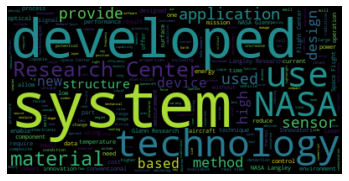

In [6]:
create_description_wordcloud(patent)

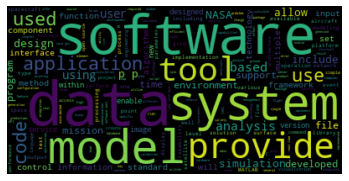

In [7]:
create_description_wordcloud(software)

## Who is getting these patents?

In [8]:
patent.groupby(["source"]).size().sort_values(ascending=False)

source
LARC    229
GSFC    140
ARC     109
GRC     101
MSFC     58
JSC      50
KSC      31
JPL      20
DFRC     19
SSC       5
dtype: int64

## And what for?

In [9]:
patent.groupby(["category"]).size().sort_values(ascending=False)

category
materials and coatings                 118
sensors                                102
aerospace                               79
mechanical and fluid systems            67
optics                                  58
electrical and electronics              44
information technology and software     43
manufacturing                           41
health medicine and biotechnology       40
robotics automation and control         35
instrumentation                         34
power generation and storage            33
communications                          29
environment                             24
propulsion                              12
undefined                                3
dtype: int64

## Do certain sources specialize?

In [84]:
patent.groupby(["source", "category"]).size().sort_values(ascending=False).head(20)

source  category                           
LARC    materials and coatings                 56
        sensors                                39
        aerospace                              31
GSFC    optics                                 29
GRC     materials and coatings                 27
ARC     aerospace                              20
GSFC    information technology and software    20
MSFC    mechanical and fluid systems           17
GSFC    electrical and electronics             17
LARC    manufacturing                          16
GSFC    sensors                                15
GRC     communications                         15
LARC    mechanical and fluid systems           14
MSFC    manufacturing                          14
LARC    instrumentation                        13
ARC     health medicine and biotechnology      13
LARC    optics                                 13
GSFC    aerospace                              12
ARC     information technology and software    12
JSC   

Text(0.5, 1.0, 'NASA: Category of Patents by Source')

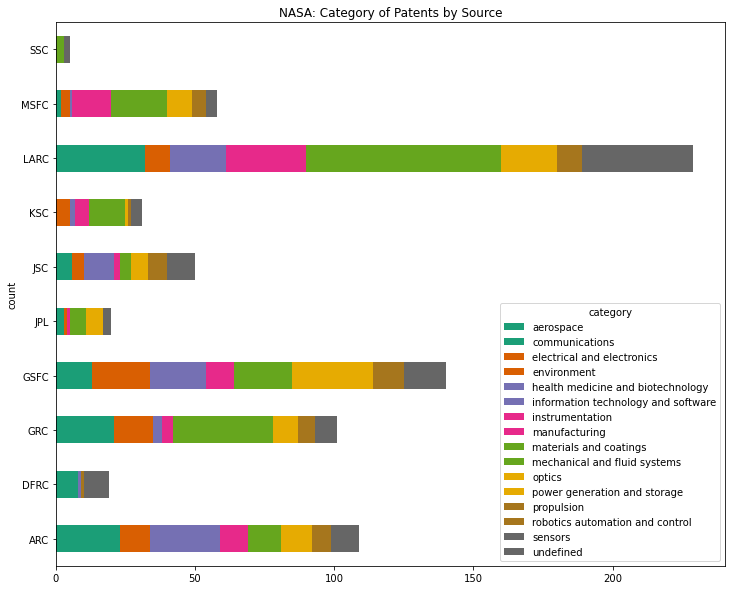

In [80]:
fig, ax = plt.subplots(figsize=(12, 10))
pd.crosstab(index=patent["source"], columns=patent["category"]).plot(
    kind="barh", stacked=True, ax=ax, colormap="Dark2"
)
ax.set_ylabel("count")
ax.set_title("NASA: Category of Patents by Source")

## Where is NASA software hosted?

We'll look at the websites and break them down by hosting provider.

In [10]:
def top_level(url: str) -> str:
    search_strings = [".gov", ".com", ".org", ".net", ".io"]
    for search in search_strings:
        if search in url:
            return (
                (url.lstrip().split(search)[0] + search)
                .split("//")[-1]
                .replace("www.", "")
            )

In [11]:
def categorize_sources(urls: list):
    return [top_level(url) for url in urls]

In [12]:
data = dict(
    Counter(
        categorize_sources(
            [entry for entry in list(software["website"]) if len(entry) > 0]
        )
    ).most_common()
)
names = list(data.keys())
values = list(data.values())

In [13]:
def significant_labels(names, values):
    labels = []
    for i, e in enumerate(values):
        if (e / sum(values)) * 100 > 2:
            labels.append(names[i])
        else:
            labels.append("")
    return labels

In [14]:
def significant_autopct(pct):
    return ("%1.1f" % pct) if pct > 1 else ""

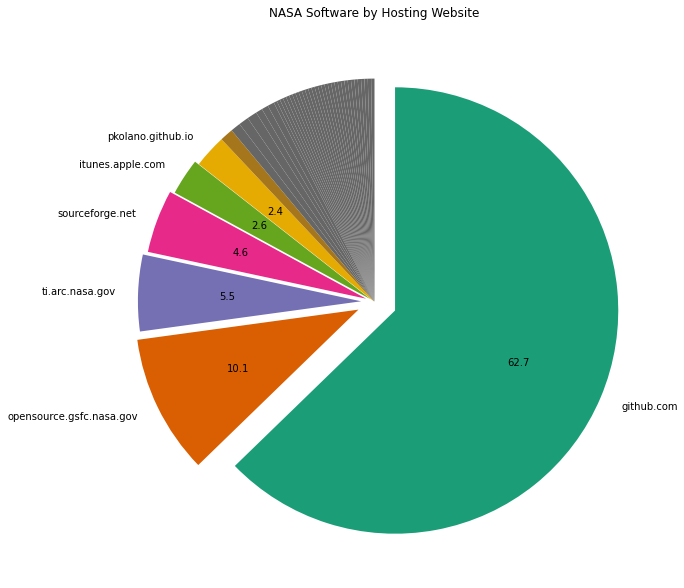

In [79]:
fig, ax = plt.subplots(figsize=(10, 20))
cmap = plt.get_cmap("Dark2")
colors = cmap(np.array(range(len(names))))
v = np.zeros(len(values))
for i in range(5):
    v[i] = 0.1 - i * 0.02
plt.pie(
    values,
    labels=significant_labels(names, values),
    autopct=significant_autopct,
    startangle=90,
    counterclock=False,
    colors=colors,
    explode=v,
)
plt.title("NASA Software by Hosting Website")
plt.show()